In [1]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit
from collections import Counter

In [2]:
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store() # we require this to read 
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T000810Z_tier_raw.lh5'

In [3]:
f = open('channel_maps.json','r')
cmap = json.load(f)

In the following section all the bege detector are extracted from the json file. Then all these detectors are added a ch to the beginning this is because the json file stores just the numbers of the detectors but these are differently stored in the files.

In [4]:
target_bege = "bege"

matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == target_bege]

In [5]:
ch = "ch"

detectors_bege = [ch+element for element in matching_bege]

**Initial Imports**

In this section I import all the data and form dictionaries so the data can easily be acsessed throughout the notebook. 

In [6]:
tb_data_dict = {}  # Dictionary to store tb_data for each detector
wfs_all_dict = {}  # Dictionary to store wfs_all for each detector

for j in detectors_bege:
    tb_data_dict[j] = sto.read_object(f'/{j}/raw', fw_new1)[0] # data 
    wfs_all_dict[j] = tb_data_dict[j]['waveform']['values'].nda # waveforms 

**Minimum value determination**

Determining the minimum values of the waveforms.

In [7]:
def minimum_values(wfs_all_dict,index):
    """ Determines the minimum values of the waveform.
    Inputs:
    wfs_all_dict - dictionary to access the waveforms 
    index - detector name 
    Outputs:
    min_values - minimum values of the waveforms for the detector index
    """
    wfs_all = wfs_all_dict[index] #extracts all waveforms in a detector 
    min_values = [] #empty list to store the minimum values 
    
    # Loop through all waveforms to find the min values 
    for i in range(len(wfs_all)):
        wf0 = wfs_all[i, :]
        # Find min values of the current waveform
        wf_min = np.min(wf0)
        # Append min values to the empty list
        min_values.append(wf_min)
    return min_values

In [8]:
minimum_dict={}
for j in detectors_bege:
    minimum_dict[j]=minimum_values(wfs_all_dict,j)

In [9]:
#plotting the minima 
for detector, min_values in minimum_dict.items():
    #plt.plot(min_values,'.')
    #plt.xlabel('Waveform index') 
    #plt.ylabel('Minimum Values (V)')
    #plt.title('Minimum Values')
    #plt.show()

SyntaxError: unexpected EOF while parsing (<ipython-input-9-03982e307693>, line 7)

**Initial cuts**

All discharge events typically have a smaller minimum value than calibration events or baseline event and hence they can be removed using the z-score.

In [ ]:
def zcalc(zscore_threshold,min_values):
    """ Calculates the z-score of the min_values and removes values beyond a 
    threshold number of deviations from the mean using the zscore_threshold.
    Inputs:
    zscore_threshold - number of standard deviations from the mean to remove a minimum point
    min_values - The array of minimum values 
    """
    # z-score of the minima
    min_z_scores = zscore(min_values)
    
    # empty lists to store the values 
    filtered_min_values = []
    skipped_min_values= []
    index_skip = []
    index_filter = []
    
    #loop through the z-score  and eliminate uncessary results
    for i, z_score in enumerate(min_z_scores):
        # Check if the minimum is beyond the mean by the threshold standard deviation 
        # we keep these values 
        if z_score < -zscore_threshold:
            skipped_min_values.append(min_values[i])
            index_skip.append(i)
            continue
        
        # If not beyond the threshold they are appended as values removed 
        filtered_min_values.append(min_values[i])
        index_filter.append(i)
        
    return filtered_min_values,skipped_min_values,index_skip,index_filter

In [ ]:
threshold = 1 #choose one standard deviation as the threshold
filtered_values ={}
skipped_values = {}
skipped_index = {}
filtered_index = {}

for j in detectors_bege:
    filtered_values[j],skipped_values[j],skipped_index[j],filtered_index[j]=zcalc(threshold,minimum_dict[j])

In [ ]:
#plotting the minima with those minima which have been removed through the first cut 
# and the minima which survived the cut 
for detector in detectors_bege:
    #plt.plot(filtered_index[detector],filtered_values[detector], '.',label=f'Removed values')
    #plt.plot(skipped_index[detector],skipped_values[detector], '.',label=f'Skipped values')

    #plt.xlabel('Waveform index') 
    #plt.ylabel('Minimum Values (V)') 
    #plt.title('Filtered and Skipped Minimum Values')
    #plt.legend()
    #plt.show()


Here we have a slight deviation as we needed to determine the range of the baseline.

In [ ]:
range_bege = []
all_bege =[]
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    filters = filtered_index[j] #taking the removed waveforms from the first cut 
    for i in filters:
        wf0 = wfs_all[i, :]
        wf_min = np.min(wf0) 
        wf_max = np.max(wf0)
        diff = wf_max - wf_min #range of the waveform
        std = np.std(wf0) 
        all_bege.append(std)

        if std < 13: #this value was picked after checking the smallest standard deviation in all waveforms 
            range_bege.append(diff)
            #ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            #plt.plot(ts[:], wf0[:], '.', label=f'Event {i}')  # plot each skipped waveform
            #plt.xlabel('Time ($\mu s$)')
            #plt.ylabel('Voltage (mV)')
            #plt.title(f'Skipped events in detector {j} which is a')
            #plt.legend()
            #plt.show()

In [ ]:
integer_list = [int(value) for value in all_bege] # converts all standard deviations into integers 

no_std = Counter(integer_list) #number of each standard deviation

for number in sorted(no_std): 
    print(f"{number}: {no_std[number]} times")

In [ ]:
standard = np.std(range_bege) #standard deviation of ranges
se = standard/len(range_bege) #error of the mean 
print(se/2)
print(np.mean(range_bege)/2) # we want the deviation ie ± of the baseline so we divide the range by 2 

Another cut is necessary to remove the calibration events which will be conducted using the maximum values of the waveforms.

In [ ]:
def maximum_values(wfs_all_dict,index):
    """Determines the maximum values of the waveform.
    Inputs:
    wfs_all_dict - dictionary to access the waveforms 
    index - detector name 
    Outputs:
    max_values - maximum values of the waveforms for the detector index
    """
    wfs_all = wfs_all_dict[index]#extracts all waveforms in a detector
    index_skip = skipped_index[index] #extract the remaining waveforms from the initial cut
    
    max_values = []#empty list to store the minimum values
    # Loop through all waveforms to find the max values
    for i in index_skip:
        wf0 = wfs_all[i, :]
        # Find max values of the current waveform
        wf_max = np.max(wf0)
        # Append max values to the list
        max_values.append(wf_max)
    
    return max_values

In [ ]:
maximum_dict={}

for j in detectors_bege:
    maximum_dict[j]=maximum_values(wfs_all_dict,j)

In [ ]:
for detector, min_values in maximum_dict.items():
    #plt.plot(min_values,'.')

    #plt.xlabel('Wavefrom index') 
    #plt.ylabel('Maximum Values (V)')  
    #plt.title('Maximum Values')
    #plt.show()

In [ ]:
def zcalc_max(zscore_threshold,maximum_values,index):
    """Calculates the z-score of the maximum_values and removes values beyond 
    a certain number of standard deviations from the mean using the zscore_threshold.
    Inputs:
    zscore_threshold - number of standard deviations from the mean to remove a maximum point
    maximum_values - The array of maximum values 
    index - detector name 
    """
    # Calculate Z-scores for the maximum values
    max_z_scores = zscore(maximum_values)
    index_skip = skipped_index[index] # waveforms which survived the first vut 
    max_values = maximum_dict[index] #maximum values 

    # Empty lists to store filtered and skipped max values and their indices
    filtered_max_values = []
    skipped_max_values = []
    index_skipm = []
    index_filterm = []
    
    #loop through the z-score  and eliminate uncessary results
    for i, z_score in enumerate(max_z_scores):
        # Check if the maximum is beyond the mean by the threshold standard deviation 
        # we keep these values 
        if abs(z_score) > zscore_threshold:
            skipped_max_values.append(max_values[i])
            index_skipm.append(index_skip[i])
            continue
        
        # If not beyond the threshold they are appended as values removed 
        filtered_max_values.append(max_values[i])
        index_filterm.append(index_skip[i])
    
    return filtered_max_values,skipped_max_values,index_skipm,index_filterm

In [ ]:
threshold =1 #choose one standard deviation as the threshold
filtered_max_values = {}
skipped_max_values = {}
index_skipm = {}
index_filterm = {}

for j in detectors_bege:
    #if the number of values in the data set is less than 20
    #the data set doesnt need to undergo a cut and all the discharge 
    #events have been removed in cut one 
    if len(maximum_dict[j])>20:
        filtered_max_values[j],skipped_max_values[j],index_skipm[j],index_filterm[j]=zcalc_max(threshold,maximum_dict[j],j)
    else:
        index_skipm[j]=skipped_index[j]    

In [ ]:
for detector in detectors_bege:
    #plt.plot(index_filterm[detector],filtered_max_values[detector], '.',label=f'Removed values')
    #plt.plot(index_skipm[detector],skipped_max_values[detector], '.',label=f'Skipped values')

    #plt.xlabel('Waveform ndex') 
    #plt.ylabel('Maximum Values (V)')
    #plt.title('Filtered and Skipped Maximum Values')
    #plt.legend()
    #plt.show()


In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['Detector Name', 'Percentage of discharge events'])

percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []

for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]

    if len(index_skip1) < 20: 
        skipped_waveforms[j] = index_skip1  
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:] #removes the ch from the detector name 
            test = cmap[x]['type'] #searches the type of detector the detector is 

            plt.plot(ts[:], wf0[:], label=f'Event {i}') 
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

        diff = len(minimum_dict[j]) - len(index_skip1) 
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        print(f"Percentage of discharges present: {percentage}%")
        #plt.show() 
    else:
        #if the dataset has more than 20 data points then the data set has no discharges
        percent_discharge[j] = 0
        print(f"This detector {j} doesn't have any discharges")

In [ ]:

for j in detectors_bege:
    df = df.append({
    'Detector Name': j,
    'Percentage of discharge events':percent_discharge[j],
    }, ignore_index=True)
    

In [ ]:
excel_filename = 'number_of_bege.xlsx'
df.to_excel(excel_filename, index=False)

The maximum difference5138.400000000001
Index for the maximum difference: 6
Corresponding x values: 438.40000000000003, 5576.8


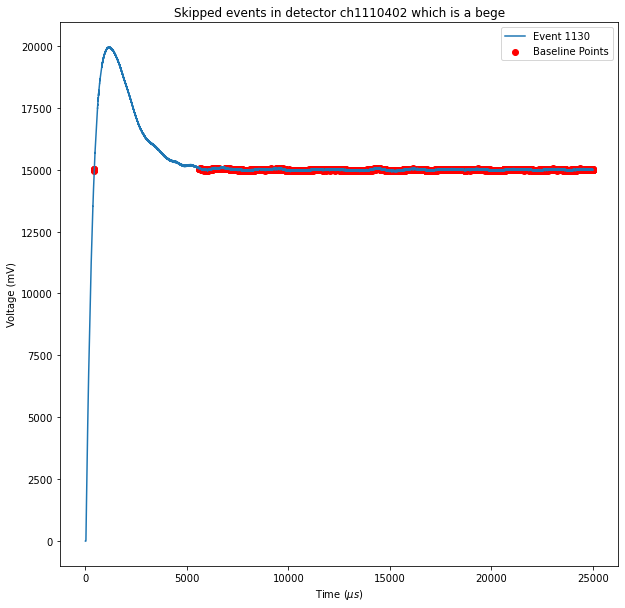

The maximum difference4889.6
Index for the maximum difference: 6
Corresponding x values: 496.0, 5385.6


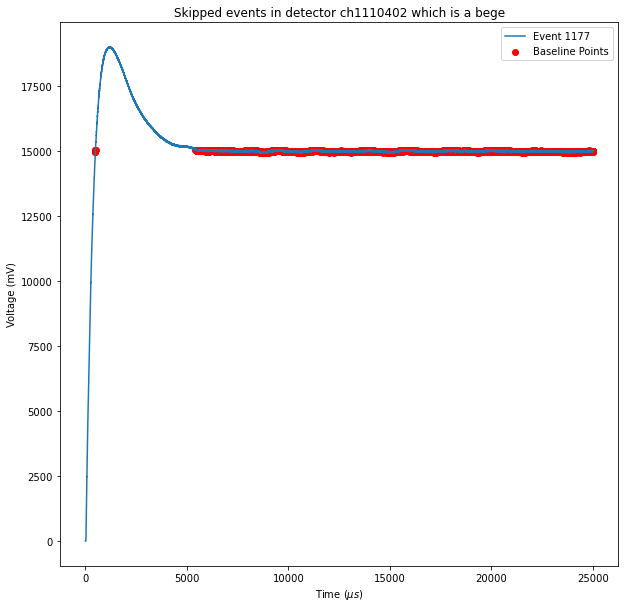

The maximum difference2702.4000000000015
Index for the maximum difference: 18685
Corresponding x values: 16123.2, 18825.600000000002


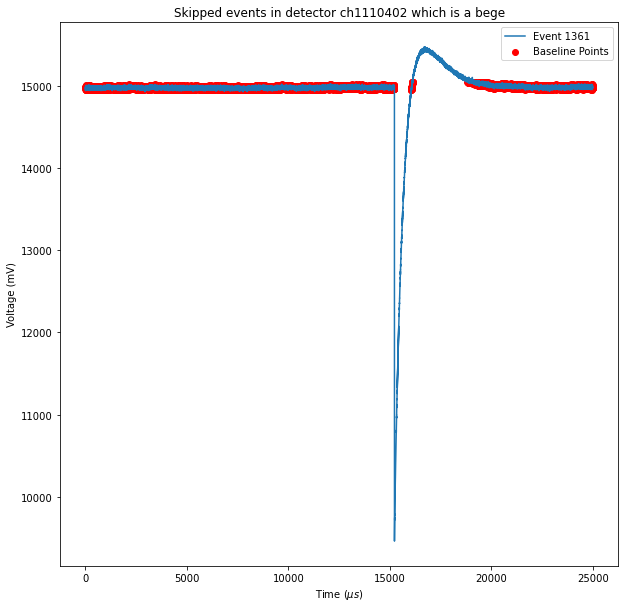

The maximum difference570.3999999999978
Index for the maximum difference: 26777
Corresponding x values: 21425.600000000002, 21996.0


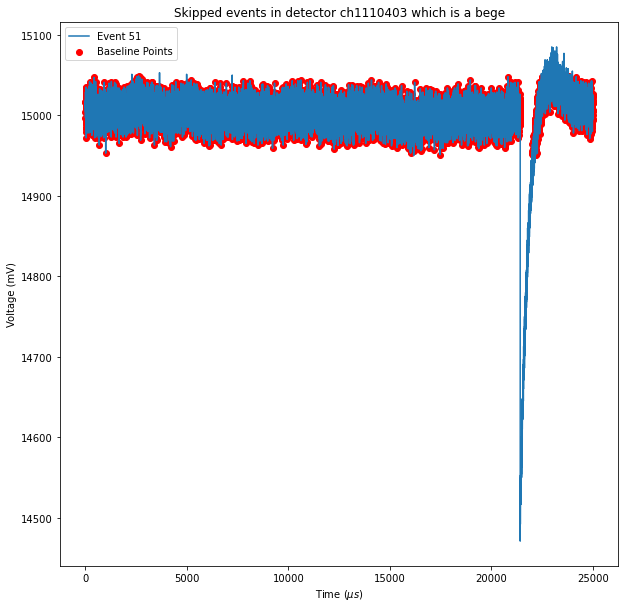

The maximum difference2795.2000000000003
Index for the maximum difference: 101
Corresponding x values: 930.4000000000001, 3725.6000000000004


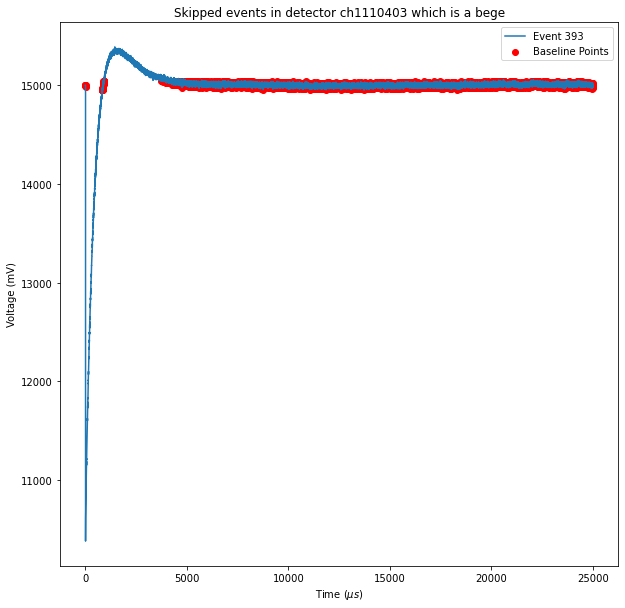

The maximum difference2704.8
Index for the maximum difference: 32
Corresponding x values: 228.8, 2933.6000000000004


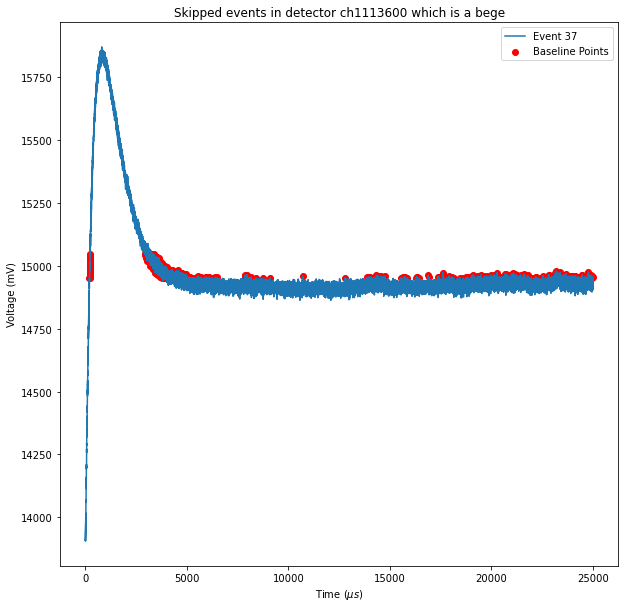

The maximum difference2016.8000000000002
Index for the maximum difference: 132
Corresponding x values: 606.4, 2623.2000000000003


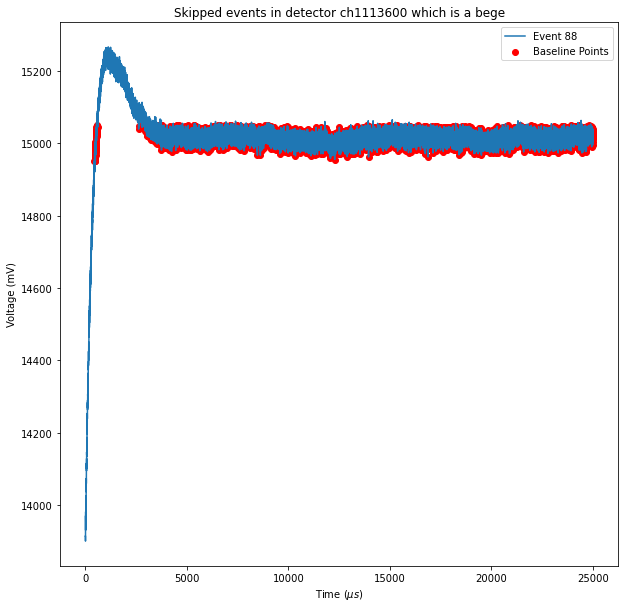

The maximum difference1754.4
Index for the maximum difference: 137
Corresponding x values: 573.6, 2328.0


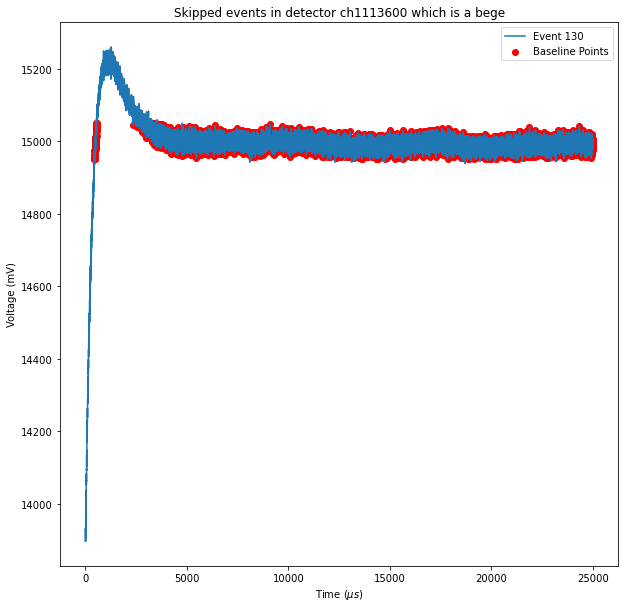

The maximum difference1622.4
Index for the maximum difference: 122
Corresponding x values: 582.4, 2204.8


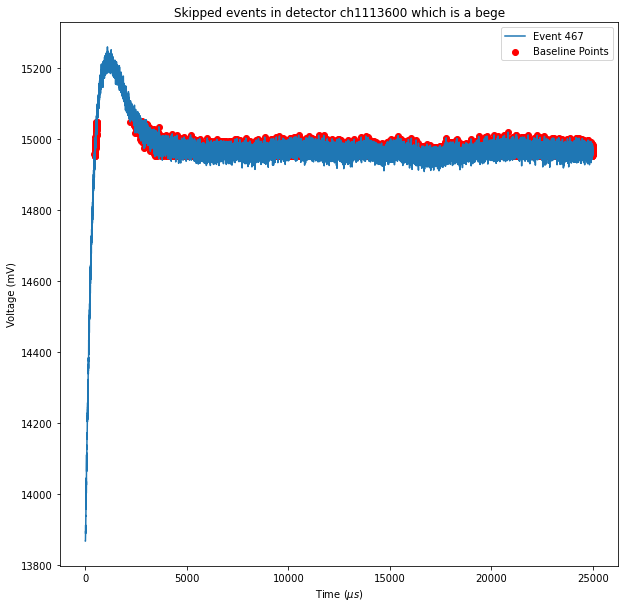

The maximum difference2341.6000000000004
Index for the maximum difference: 71
Corresponding x values: 391.20000000000005, 2732.8


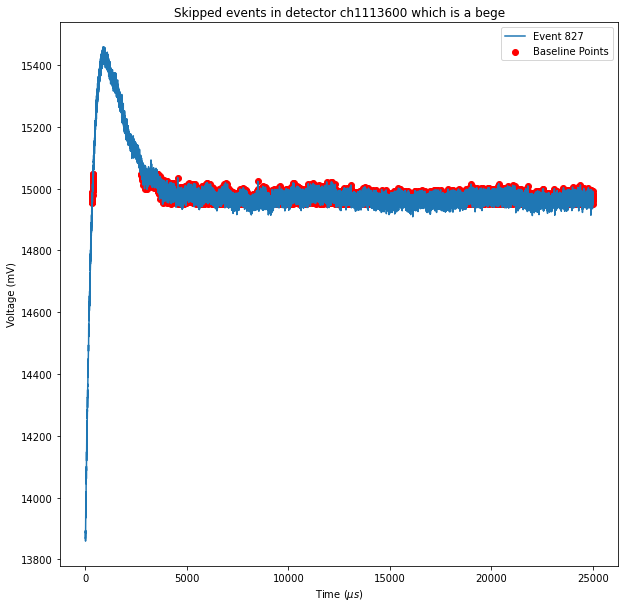

The maximum difference1965.6000000000001
Index for the maximum difference: 126
Corresponding x values: 575.2, 2540.8


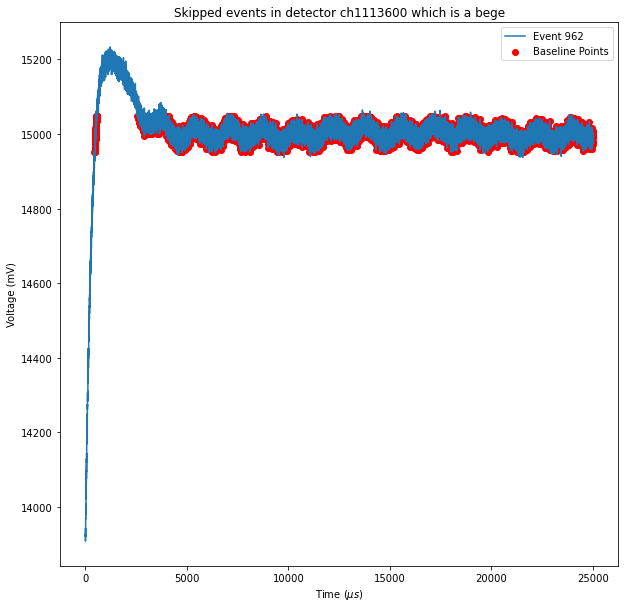

The maximum difference6313.5999999999985
Index for the maximum difference: 6
Corresponding x values: 12870.400000000001, 19184.0


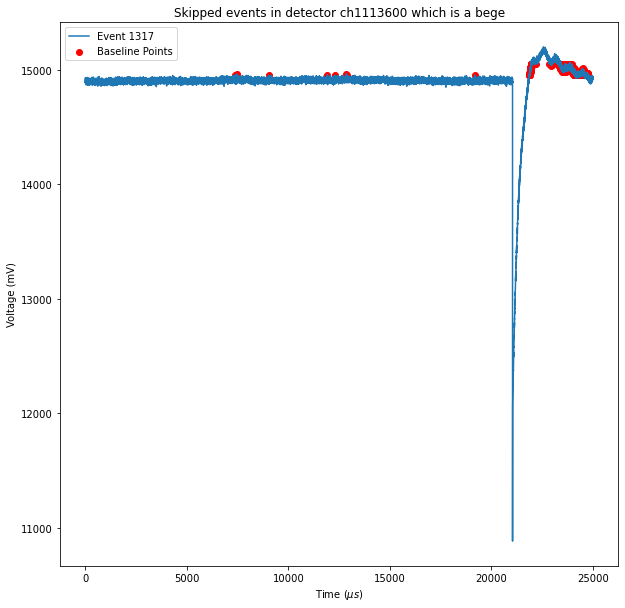

The maximum difference5882.400000000001
Index for the maximum difference: 1
Corresponding x values: 227.20000000000002, 6109.6


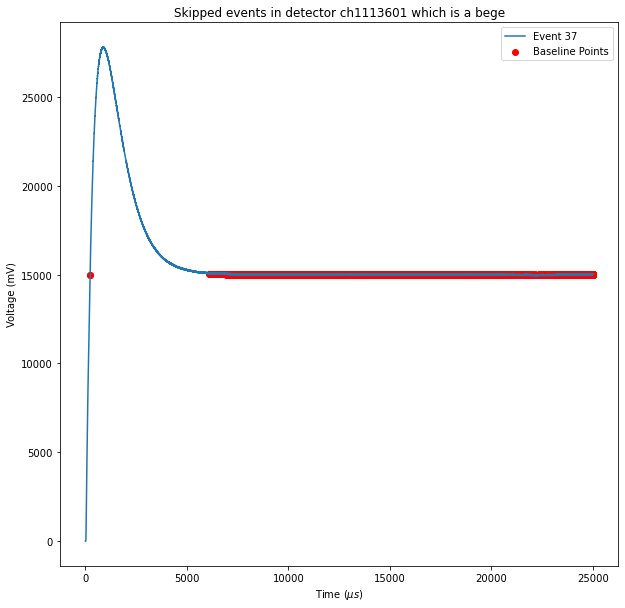

The maximum difference4308.000000000001
Index for the maximum difference: 9
Corresponding x values: 562.4, 4870.400000000001


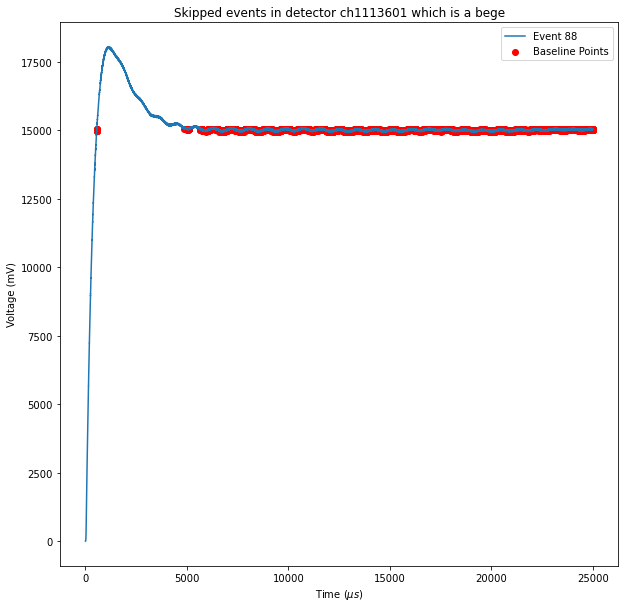

The maximum difference4825.6
Index for the maximum difference: 8
Corresponding x values: 518.4, 5344.0


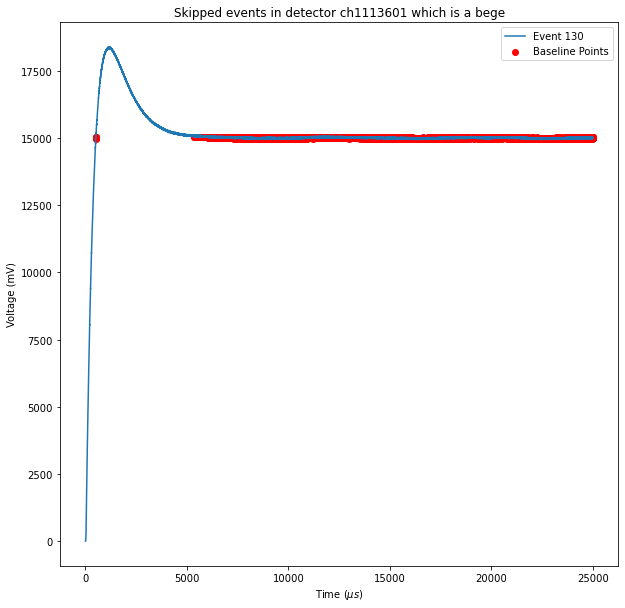

The maximum difference4513.6
Index for the maximum difference: 8
Corresponding x values: 496.0, 5009.6


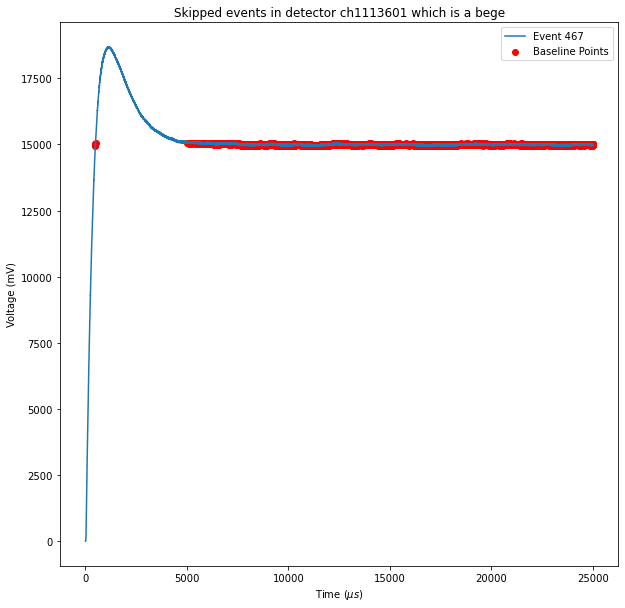

The maximum difference704.7999999999993
Index for the maximum difference: 22703
Corresponding x values: 18511.2, 19216.0


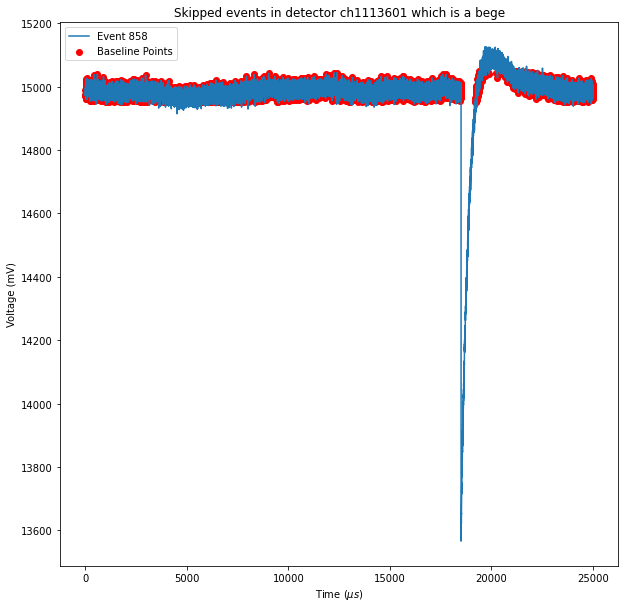

The maximum difference3776.0
Index for the maximum difference: 10
Corresponding x values: 536.8000000000001, 4312.8


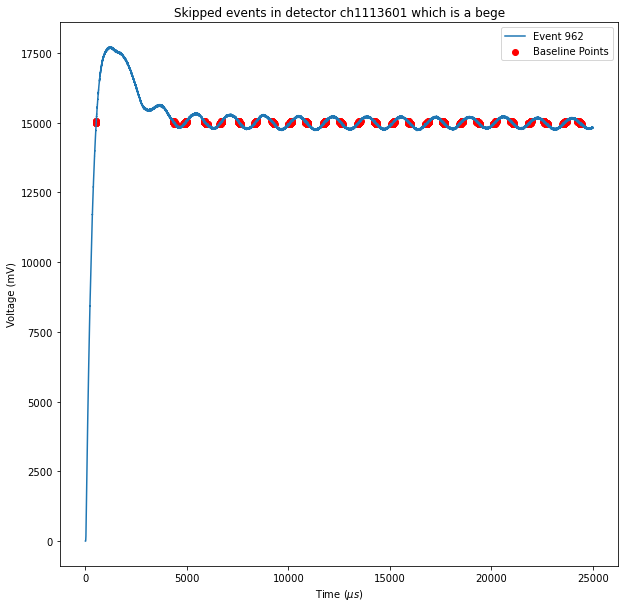

The maximum difference2400.8
Index for the maximum difference: 108
Corresponding x values: 561.6, 2962.4


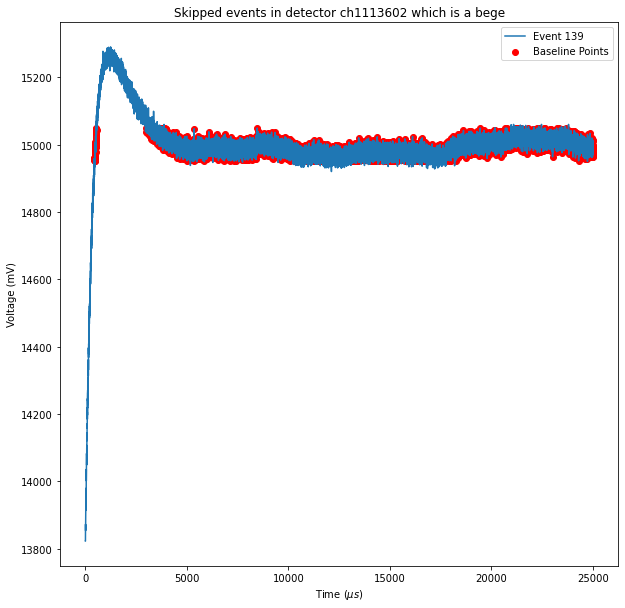

The maximum difference3955.2000000000007
Index for the maximum difference: 20905
Corresponding x values: 19338.4, 23293.600000000002


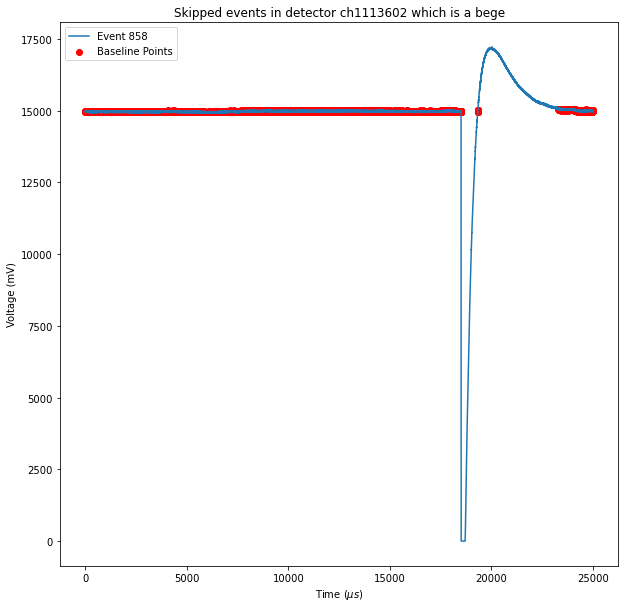

The maximum difference2009.6000000000004
Index for the maximum difference: 120
Corresponding x values: 585.6, 2595.2000000000003


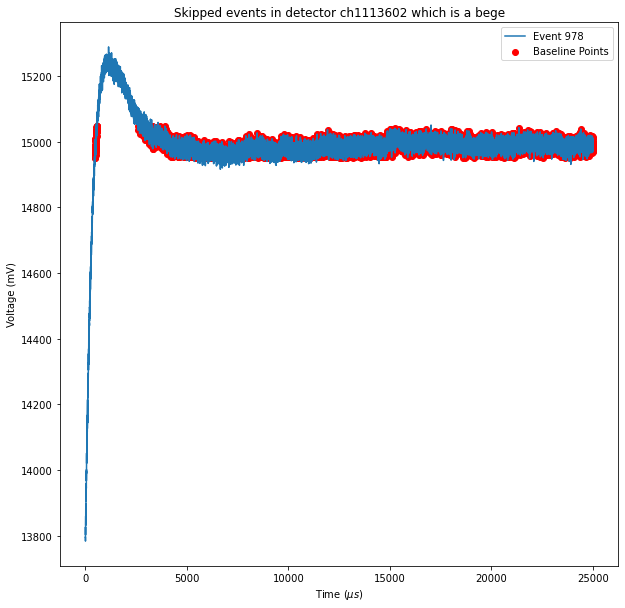

The maximum difference3043.2
Index for the maximum difference: 56
Corresponding x values: 319.20000000000005, 3362.4


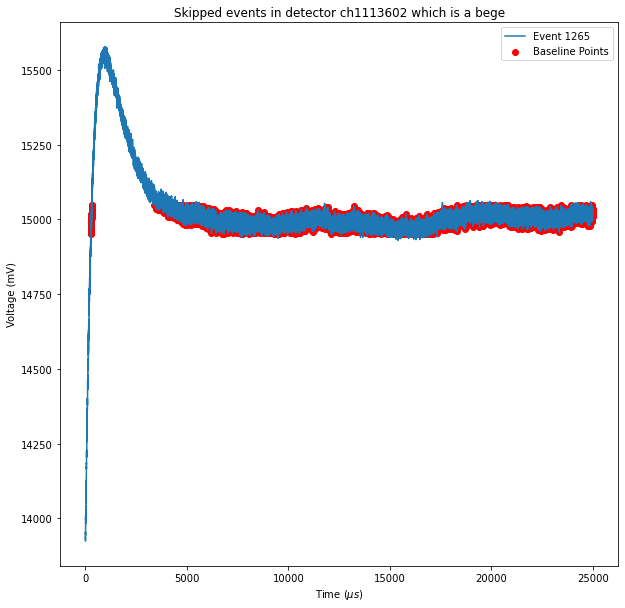

The maximum difference4532.8
Index for the maximum difference: 5
Corresponding x values: 472.8, 5005.6


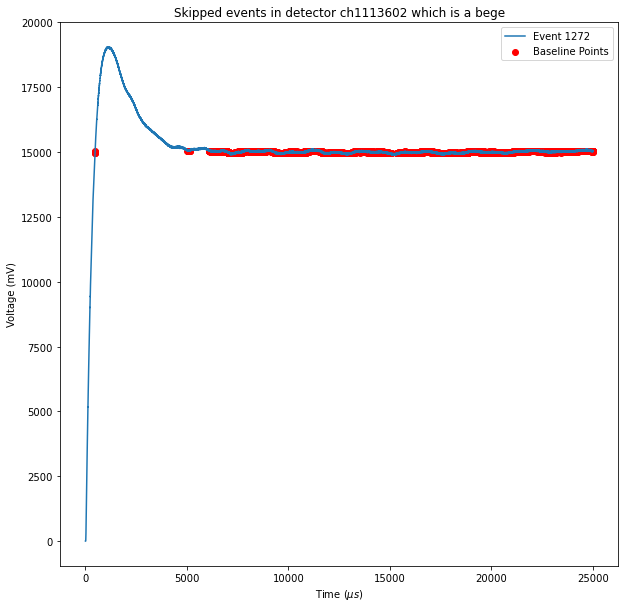

The maximum difference708.0
Index for the maximum difference: 16723
Corresponding x values: 14439.2, 15147.2


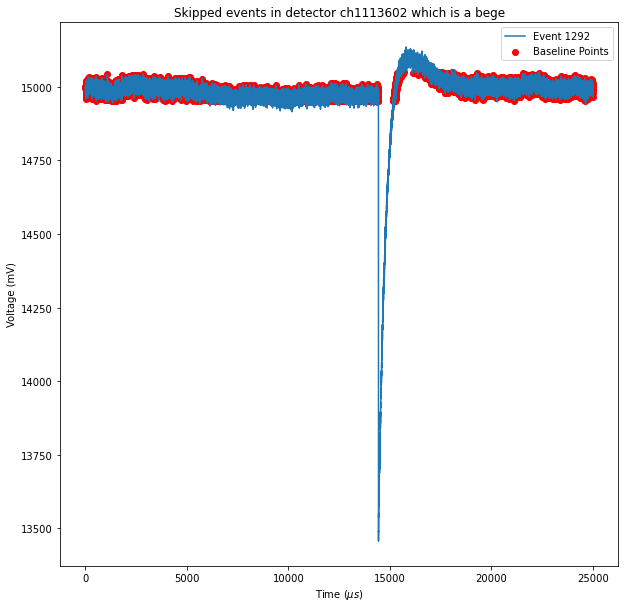

The maximum difference6588.000000000001
Index for the maximum difference: 7
Corresponding x values: 547.2, 7135.200000000001


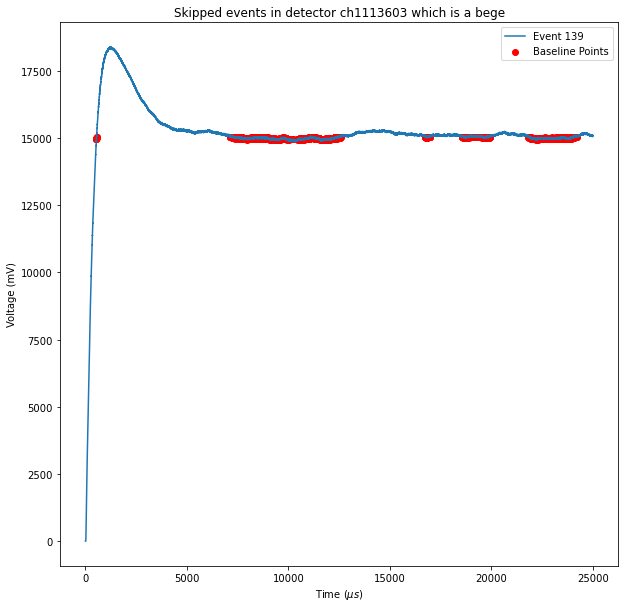

The maximum difference5843.200000000001
Index for the maximum difference: 10
Corresponding x values: 532.0, 6375.200000000001


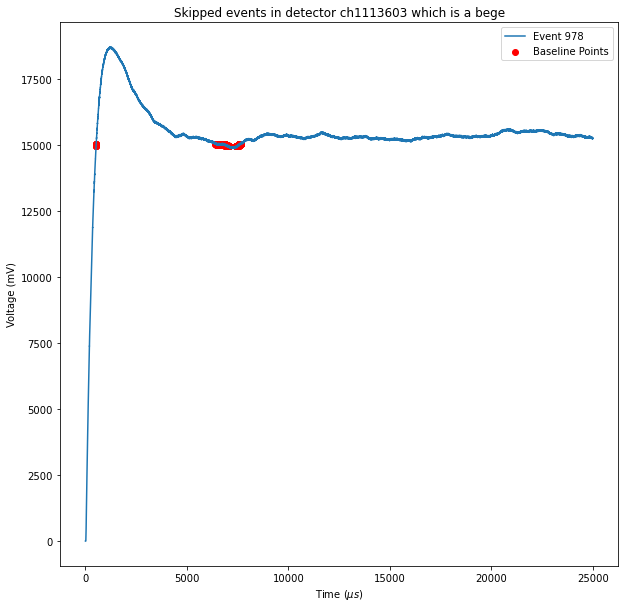

The maximum difference1169.6
Index for the maximum difference: 442
Corresponding x values: 1020.0, 2189.6


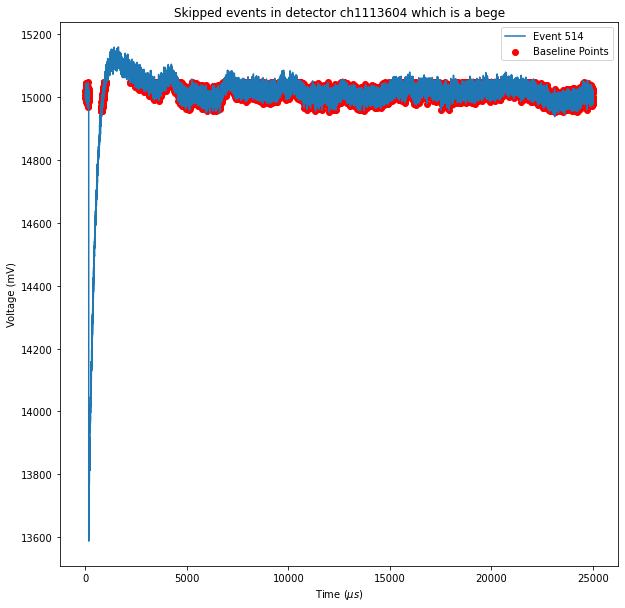

The maximum difference5765.6
Index for the maximum difference: 6
Corresponding x values: 414.40000000000003, 6180.0


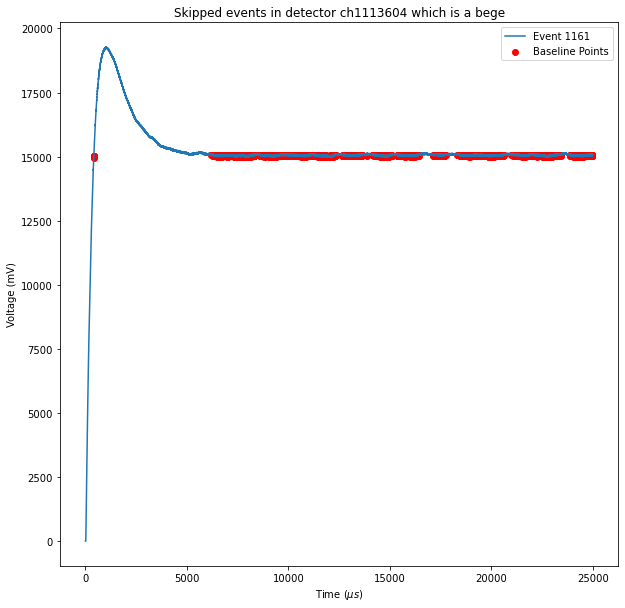

The maximum difference4899.200000000001
Index for the maximum difference: 2
Corresponding x values: 272.0, 5171.200000000001


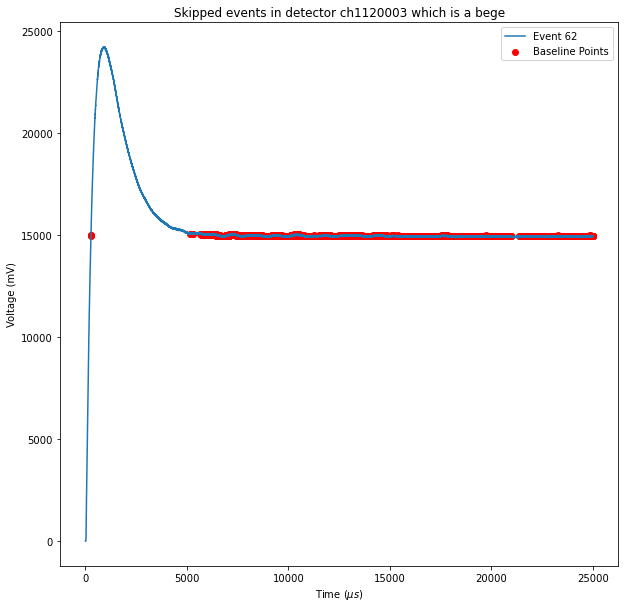

The maximum difference4515.2
Index for the maximum difference: 5
Corresponding x values: 424.8, 4940.0


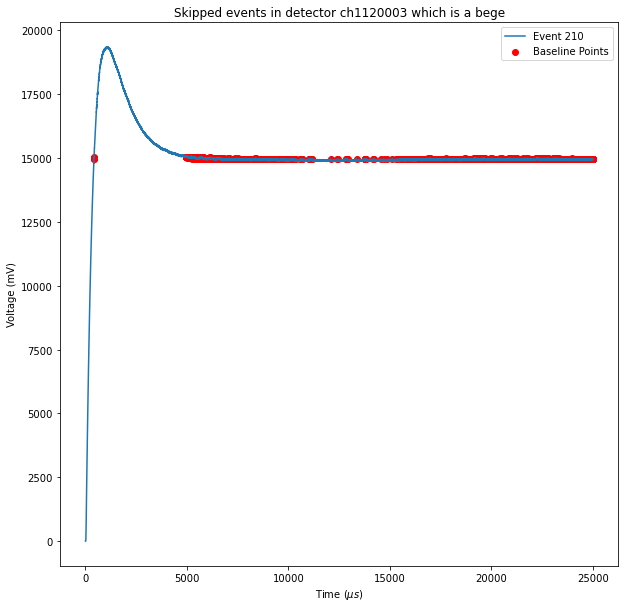

The maximum difference4548.8
Index for the maximum difference: 8
Corresponding x values: 500.8, 5049.6


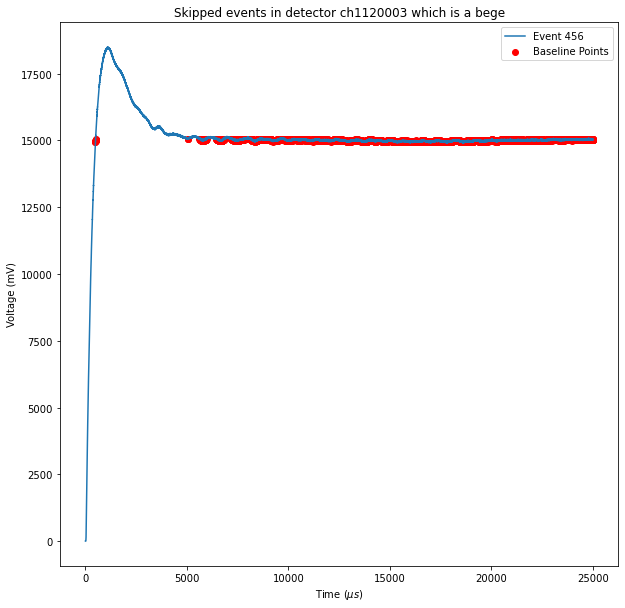

The maximum difference2910.4000000000015
Index for the maximum difference: 9765
Corresponding x values: 11296.0, 14206.400000000001


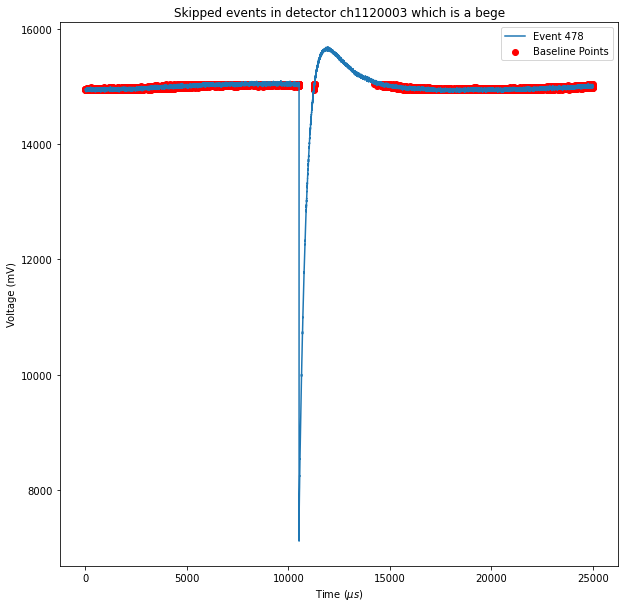

The maximum difference4893.6
Index for the maximum difference: 3
Corresponding x values: 351.20000000000005, 5244.8


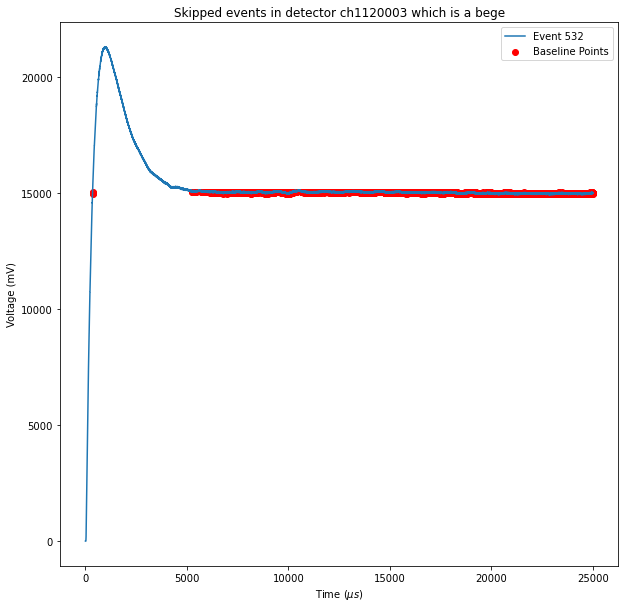

The maximum difference5203.200000000001
Index for the maximum difference: 3
Corresponding x values: 280.0, 5483.200000000001


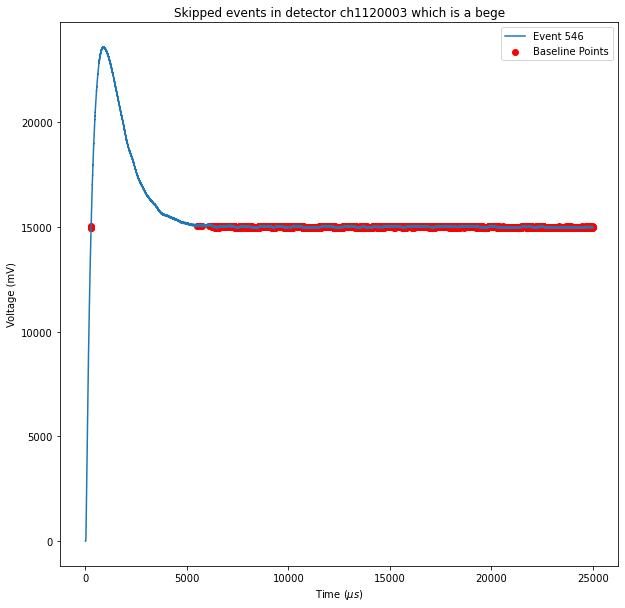

The maximum difference4205.6
Index for the maximum difference: 8
Corresponding x values: 472.0, 4677.6


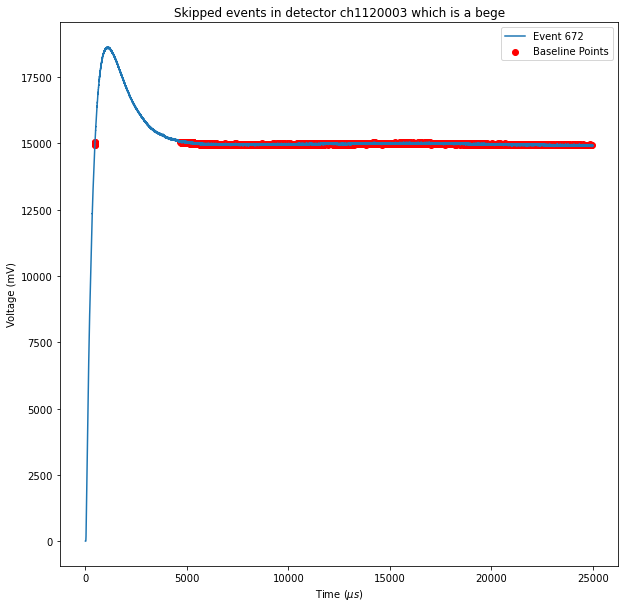

The maximum difference4391.2
Index for the maximum difference: 4
Corresponding x values: 372.0, 4763.2


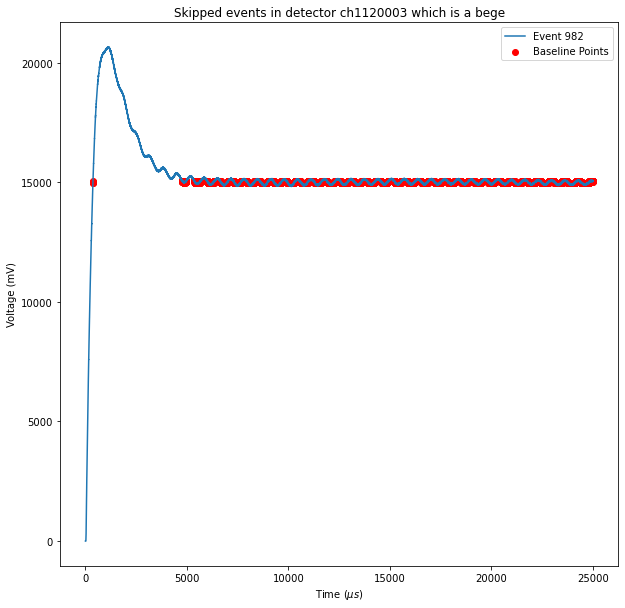

The maximum difference6225.6
Index for the maximum difference: 1
Corresponding x values: 208.8, 6434.400000000001


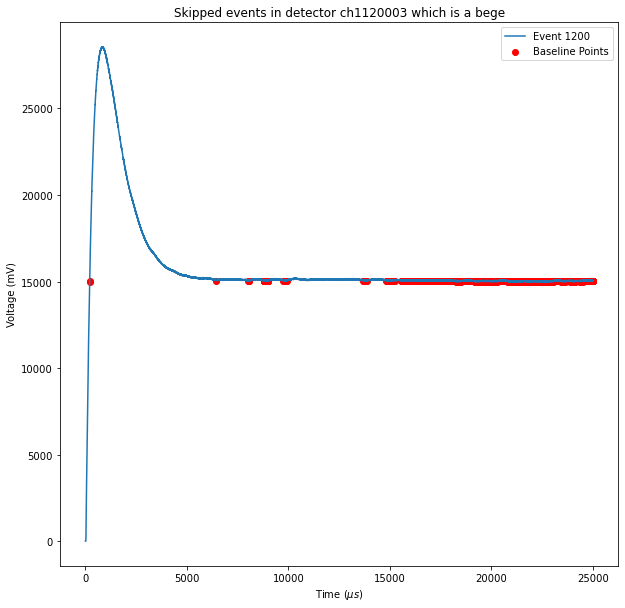

The maximum difference5241.6
Index for the maximum difference: 6
Corresponding x values: 402.40000000000003, 5644.0


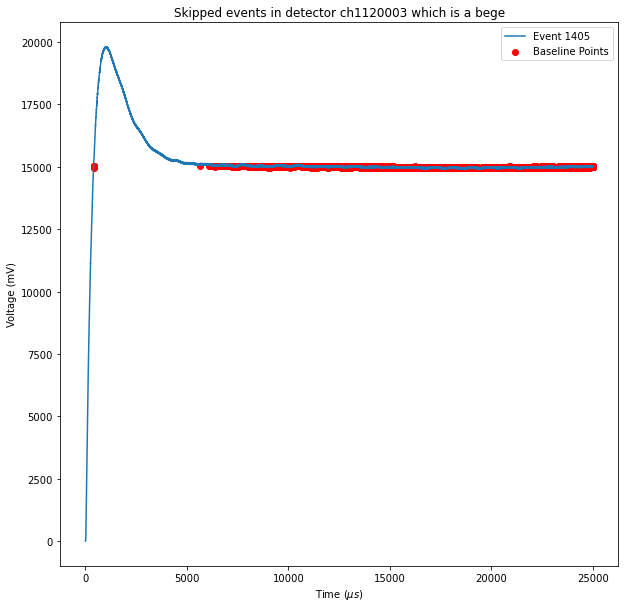

The maximum difference2264.8
Index for the maximum difference: 85
Corresponding x values: 671.2, 2936.0


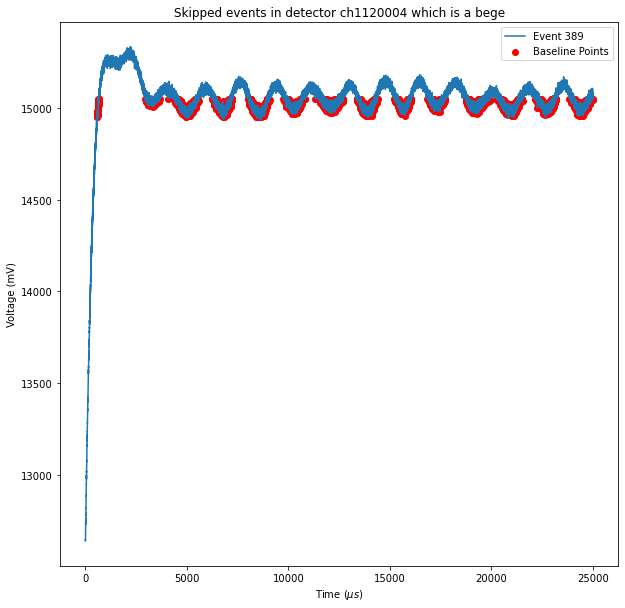

The maximum difference2272.8
Index for the maximum difference: 1234
Corresponding x values: 1790.4, 4063.2000000000003


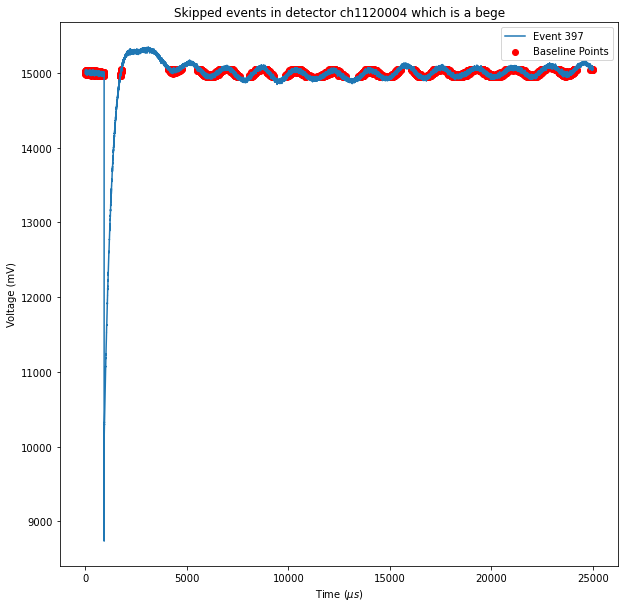

The maximum difference1833.6000000000004
Index for the maximum difference: 2223
Corresponding x values: 15125.6, 16959.2


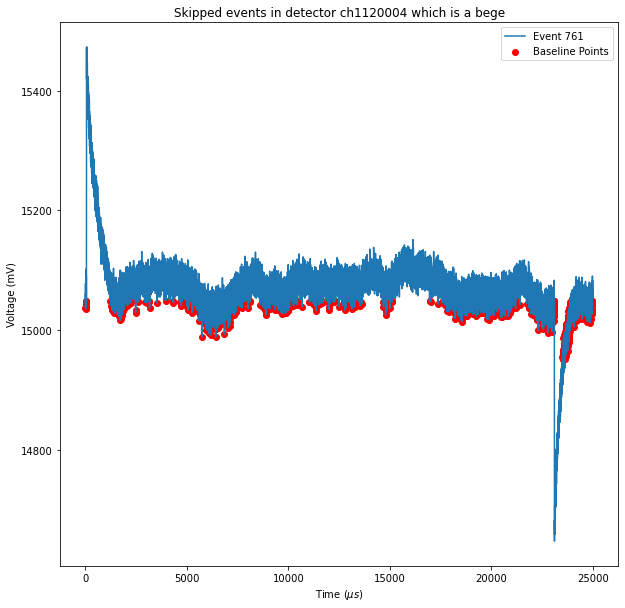

The maximum difference2234.4
Index for the maximum difference: 70
Corresponding x values: 240.8, 2475.2000000000003


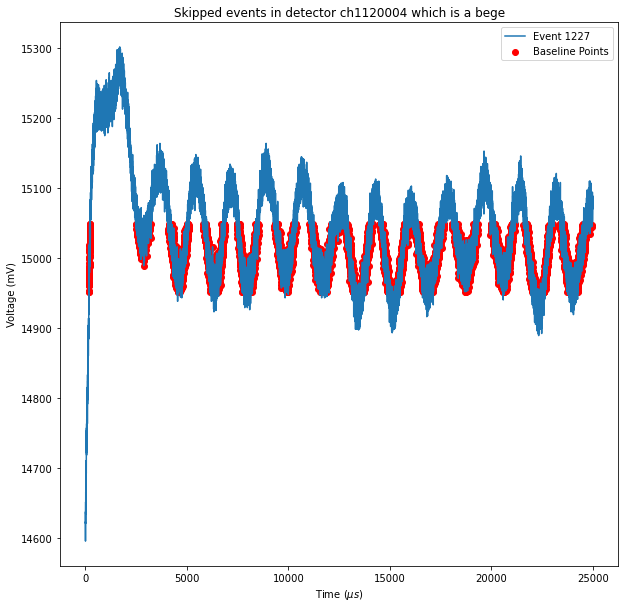

The maximum difference2555.2000000000003
Index for the maximum difference: 93
Corresponding x values: 394.40000000000003, 2949.6000000000004


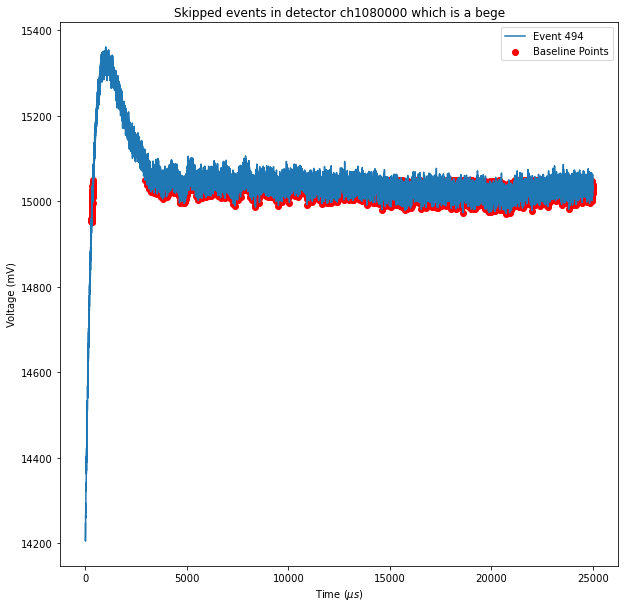

The maximum difference1658.3999999999996
Index for the maximum difference: 4502
Corresponding x values: 4505.6, 6164.0


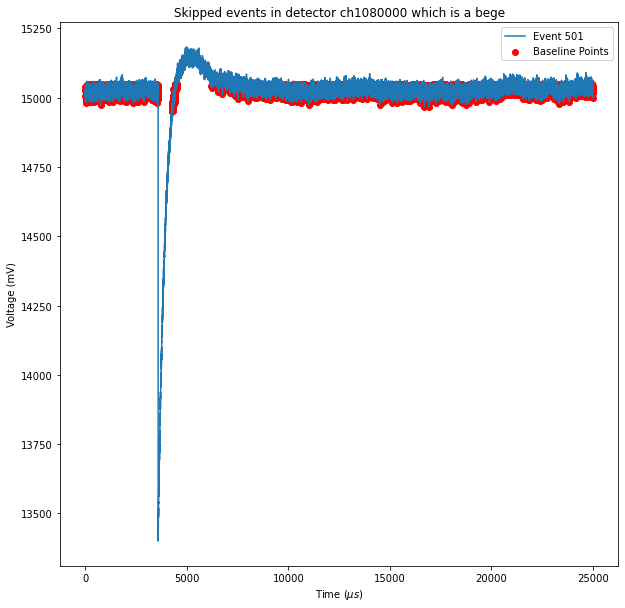

The maximum difference2833.6000000000004
Index for the maximum difference: 77
Corresponding x values: 356.0, 3189.6000000000004


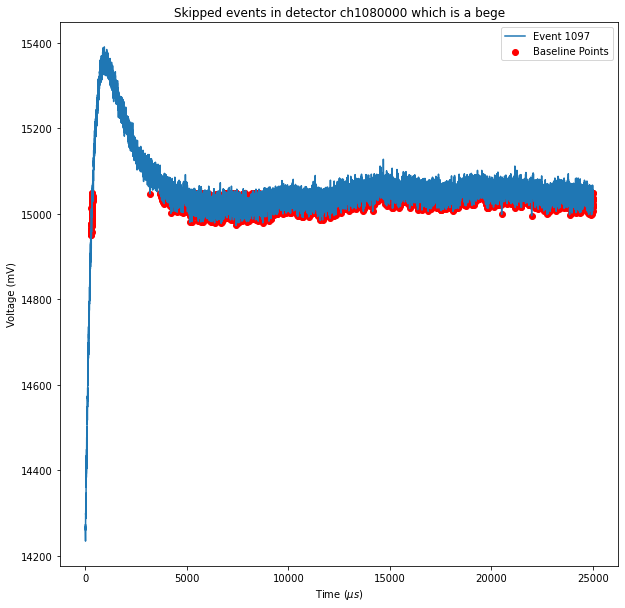

The maximum difference2912.8
Index for the maximum difference: 70
Corresponding x values: 297.6, 3210.4


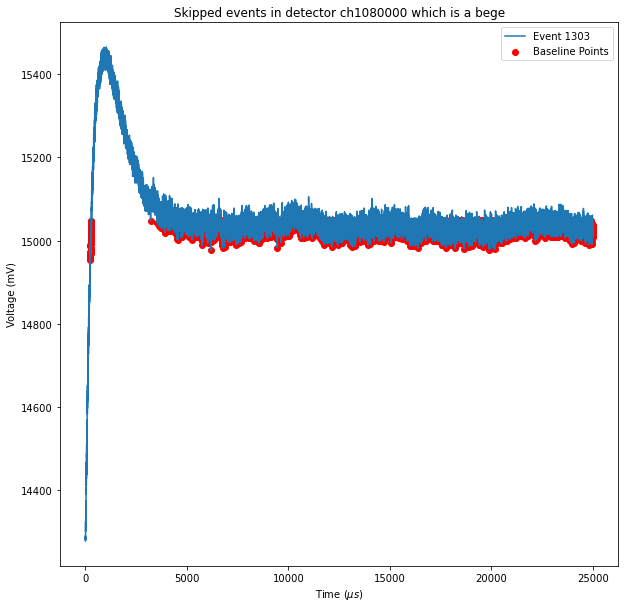

The maximum difference5092.8
Index for the maximum difference: 3
Corresponding x values: 425.6, 5518.400000000001


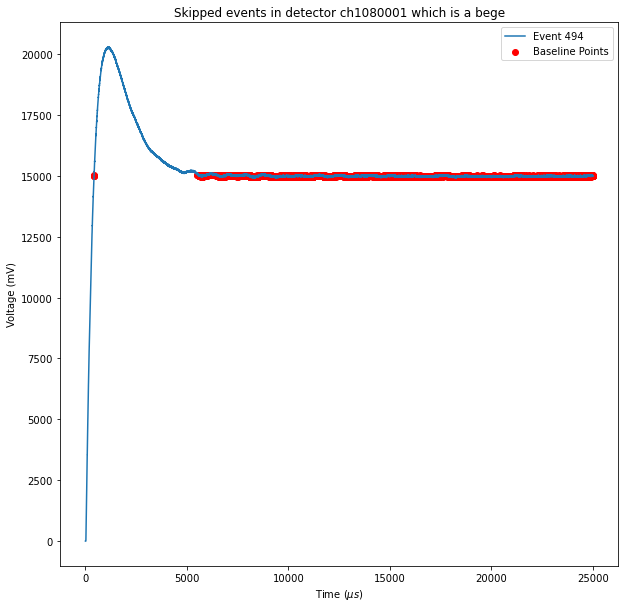

The maximum difference5484.8
Index for the maximum difference: 5
Corresponding x values: 407.20000000000005, 5892.0


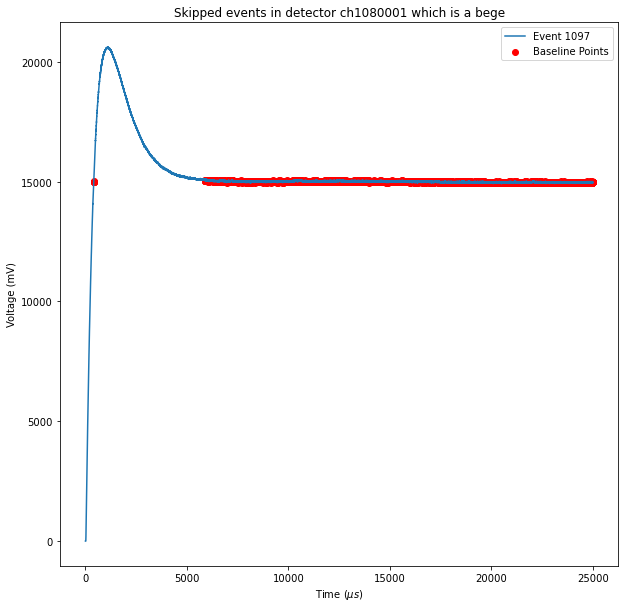

The maximum difference5263.2
Index for the maximum difference: 2
Corresponding x values: 345.6, 5608.8


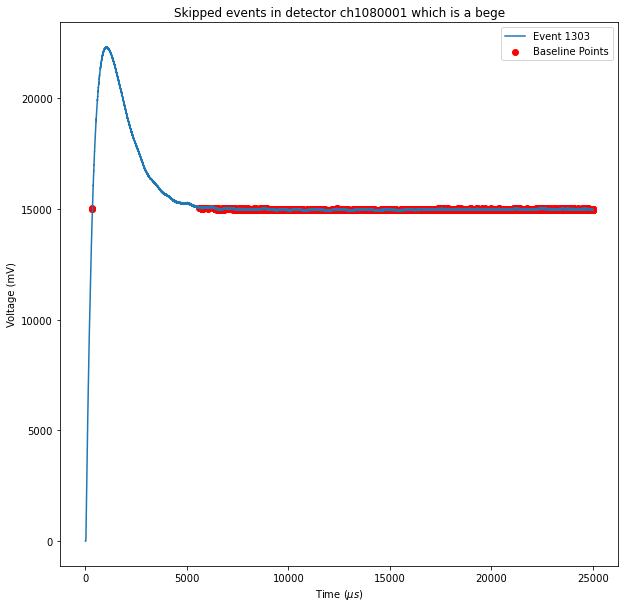

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: attempt to get argmax of an empty sequence

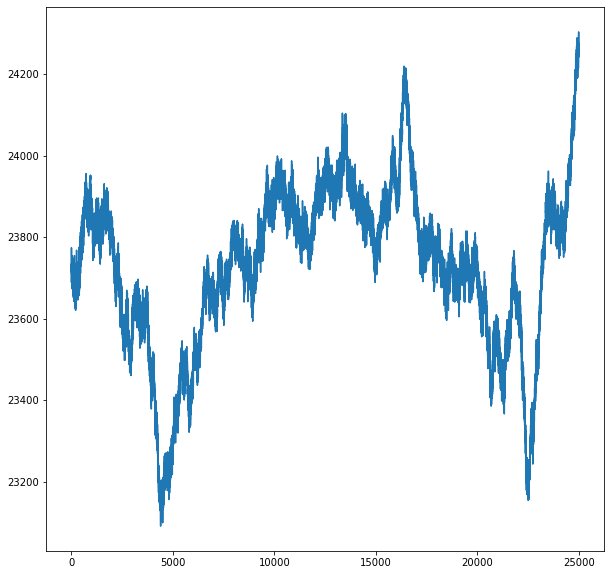

In [25]:
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    diff_values=[]
    if len(index_skip1) < 20:
        for i in index_skip1:
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            plt.plot(ts[:], wf0[:], label=f'Event {i}')  # plot each skipped waveform
            for_append = []
            for_x = []
            for t, q in zip(ts, wf0):
                if 14950 < q < 15050:
                    for_x.append(t)
                    for_append.append(q)
            mean_baseline = np.mean(for_append)
            tolerance = 2
            indices_baseline = np.where(np.abs(wf0 - mean_baseline) < tolerance)[0]
            
            # Plot the x values
            
            plt.scatter(for_x, for_append, color='r', label='Baseline Points')
            # Calculate the differences between consecutive x values
            x_diff = [for_x[i+1] - for_x[i] for i in range(len(for_x)-1)]

            # Determine the index for the maximum difference
            max_diff_index = np.argmax(x_diff)

            # Use the index to get the corresponding x values
            max_diff_x1 = for_x[max_diff_index]
            max_diff_x2 = for_x[max_diff_index + 1]
            
            # Print or use max_diff_index, max_diff_x1, max_diff_x2 as needed
            print(f"The maximum difference{np.max(x_diff)}")
            print(f"Index for the maximum difference: {max_diff_index}")
            print(f"Corresponding x values: {max_diff_x1}, {max_diff_x2}")
            
            # Customize plot
            #plt.plot(ts[indices_baseline[0]:], wf0[indices_baseline[0]:], color='k')
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()
            #time_to_baseline = x1[indices_baseline[0]:][0]
            #print(f"The time to return to baseline is {time_to_baseline} mu s")
